In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../Datasets/Fish_Market/Fish.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [3]:
headings = df.columns.tolist()
headings.remove('Species')

In [4]:
embedding_dict = {}
embedding_list = []
counter = 0
for species in df['Species'].unique():
    embedding_dict[species] = counter
    counter += 1
for species in df['Species']:
    embedding_list.append(embedding_dict[species])
df['Species_encoding'] = embedding_list

In [5]:
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width,Species_encoding
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200,0
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056,0
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961,0
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555,0
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340,0


In [6]:
y = np.array(embedding_list)
x = np.stack([df[i].values for i in headings], axis=1, )

In [7]:
x = normalize(x, axis=0)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=33)
x_test, x_validation, y_test, y_validation = train_test_split(x_test,y_test,test_size=0.2,random_state=33)

In [9]:
class Model(nn.Module):
    def __init__(self, in_features=6, h1=12, h2=16, out_features=7):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return F.log_softmax(x)

In [10]:
model = Model()
criterion = nn.CrossEntropyLoss() # good for probability of prediction so it gives a list of prediction.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
epochs =5000
losses = []
for i in range(epochs):
    i+=1
    input = torch.FloatTensor(x_train)
    labels = torch.LongTensor(y_train)
    optimizer.zero_grad()
    y_pred = model.forward(input)
    loss = criterion(y_pred, labels)
    losses.append(loss.item())

    if i%1000 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    loss.backward()
    optimizer.step()


epoch:  1  loss: 1.98091710


/var/folders/kr/503r11fj1nb27b3p5tqtpmcm0000gn/T/ipykernel_8401/4003058373.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


epoch: 1001  loss: 1.36000896
epoch: 2001  loss: 0.99420464
epoch: 3001  loss: 0.61949265
epoch: 4001  loss: 0.42810500


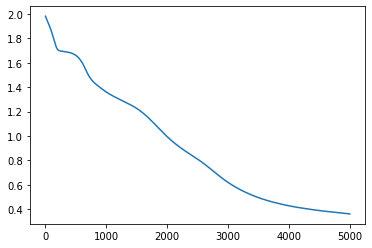

In [12]:
plt.plot(range(epochs), losses)

In [13]:
x_test_tensor = torch.FloatTensor(x_test)
y_test_tensor = torch.LongTensor(y_test)
with torch.no_grad():
    y_val = model.forward(x_test_tensor)
    loss = criterion(y_val, y_test_tensor)
print(f'{loss:.8f}')

0.43246990


/var/folders/kr/503r11fj1nb27b3p5tqtpmcm0000gn/T/ipykernel_8401/4003058373.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [14]:
correct = 0
with torch.no_grad():
    for i in range(len(x_test_tensor)):
        y_val = model.forward(x_test_tensor[i])
        if y_val.argmax().item() == y_test_tensor[i]:
            correct += 1
print(f'\n{correct} out of {len(y_test_tensor)} = {100*correct/len(y_test_tensor):.2f}% correct')


22 out of 25 = 88.00% correct


/var/folders/kr/503r11fj1nb27b3p5tqtpmcm0000gn/T/ipykernel_8401/4003058373.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [15]:
model.eval()

Model(
  (fc1): Linear(in_features=6, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=7, bias=True)
)

In [16]:
x_validation_tensor = torch.FloatTensor(x_validation)
y_validation_tensor = torch.LongTensor(y_validation)
embedding_keys_list = list(embedding_dict.keys())
with torch.no_grad():
    for i in range(len(x_validation_tensor)):
        y_val = model(x_validation_tensor[i])
        print(embedding_keys_list[y_val.argmax().item()] + ' : ' +  embedding_keys_list[y_validation_tensor[i]])


Parkki : Parkki
Bream : Bream
Bream : Bream
Parkki : Parkki
Perch : Perch
Perch : Perch
Smelt : Smelt


/var/folders/kr/503r11fj1nb27b3p5tqtpmcm0000gn/T/ipykernel_8401/4003058373.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
